In [1]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from swissgrid import grid_data as gd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import api as sm

In [2]:
total_consumption = gd.iloc[:,2]
consw = total_consumption.resample('W').sum()[1:-1] #discard first and last because incomplete

In [3]:
weather = pd.read_csv('data/weather_data_filtered.csv')
weather['timestamp'] = pd.to_datetime(weather['utc_timestamp'])
weather = weather[['timestamp', 'CH_temperature']].set_index('timestamp').sort_index()
weather = weather.tz_localize(None)

#align weather and consumption indexes
w = weather.resample('W').mean()[consw.index[0]:]
c = consw[:w.index[-1]]/1e6 #unit of measurement is now GWh

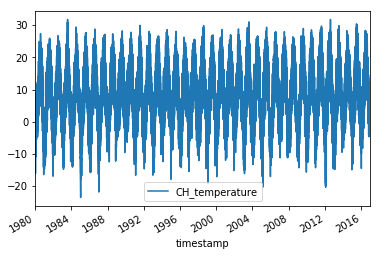

In [4]:
weather.plot()

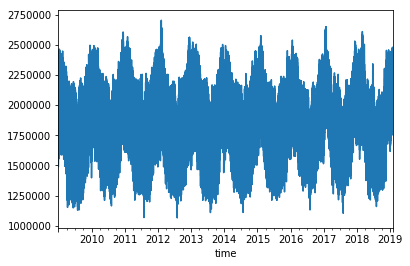

In [5]:
total_consumption.plot()

In [6]:
from sklearn.neighbors import KNeighborsRegressor

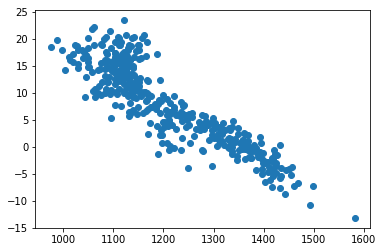

In [7]:
plt.scatter(c,w)

In [8]:
import holidays

In [9]:
holidays_ch = holidays.Switzerland()

In [10]:
# subsample total consamption
total_consumption = total_consumption.loc[total_consumption.index<= weather.index.max()]
weather = weather.loc[weather.index>=total_consumption.index.min()]
total_consumption = total_consumption.loc[weather.index]

In [11]:
days = pd.concat([total_consumption, weather], axis=1)
days['holiday'] = [x in holidays_ch for x in days.index]

In [12]:
days = days.rename(columns={'Total energy consumption Swiss controlblock':'consumption'})

In [13]:
days.iloc[24]

consumption       1.83889e+06
CH_temperature         -6.586
holiday                 False
Name: 2009-01-02 01:00:00, dtype: object

In [14]:
days['previous_day'] = days.consumption.shift(24)
days['previous_week'] = days.consumption.shift(24*7)
days['prediction'] = days.consumption.shift(-1)

In [15]:
days = days.dropna()

In [42]:
k=3
predictor_work = KNeighborsRegressor(k)
predictor_holy = KNeighborsRegressor(k)

In [43]:
days.keys()

Index(['consumption', 'CH_temperature', 'holiday', 'previous_day',
       'previous_week', 'prediction'],
      dtype='object')

In [44]:
perc = 0.9
dataset = days[['consumption', 'CH_temperature', 'previous_day', 'previous_week']]
predictor_work.fit(dataset[~days.holiday].iloc[:int(perc*len(dataset[~days.holiday]))].values,
                  days.prediction[~days.holiday].iloc[:int(perc*len(dataset[~days.holiday]))].values)
predictor_holy.fit(dataset[days.holiday].iloc[:int(perc*len(dataset[days.holiday]))].values,
                  days.prediction[days.holiday].iloc[:int(perc*len(dataset[days.holiday]))].values)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=3, p=2,
          weights='uniform')

In [45]:
work_pred = predictor_work.predict(dataset[~days.holiday].iloc[int(perc*len(dataset[~days.holiday])):].values)
holy_pred = predictor_holy.predict(dataset[days.holiday].iloc[int(perc*len(dataset[days.holiday])):].values)

In [46]:
results_w = pd.DataFrame()
results_w['date'] = dataset[~days.holiday].iloc[int(perc*len(dataset[~days.holiday])):].index
results_w['label'] = days.prediction[~days.holiday].iloc[int(perc*len(dataset[~days.holiday])):].values
results_w['prediction'] = work_pred
results_h = pd.DataFrame()
results_h['date'] = dataset[days.holiday].iloc[int(perc*len(dataset[days.holiday])):].index
results_h['label'] = days.prediction[days.holiday].iloc[int(perc*len(dataset[days.holiday])):].values
results_h['prediction'] = holy_pred
results = pd.concat([results_w, results_h]).sort_values('date')

In [47]:
def MAPE(a,b):
    assert len(a)==len(b)
    return np.sum(np.abs((a-b)/a))/len(a)

In [48]:
mape = MAPE(results.label.values, results.prediction.values)

In [49]:
mape

0.03555365518160117

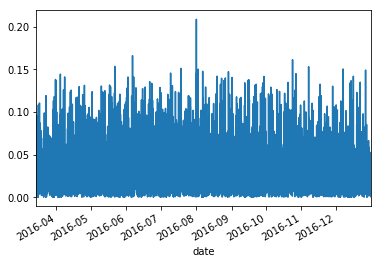

In [29]:
results.set_index('date').groupby('date').apply(lambda x: MAPE(x.label.values, x.prediction.values)).plot()

In [46]:
total_consumption.iloc[:10]

time
2009-01-01 00:30:00    1.905594e+06
2009-01-01 00:45:00    1.919726e+06
2009-01-01 01:00:00    1.891833e+06
2009-01-01 01:15:00    1.919923e+06
2009-01-01 01:30:00    1.877263e+06
2009-01-01 01:45:00    1.879273e+06
2009-01-01 02:00:00    1.837647e+06
2009-01-01 02:15:00    1.847732e+06
2009-01-01 02:30:00    1.821452e+06
2009-01-01 02:45:00    1.802385e+06
Freq: 15T, Name: Total energy consumption Swiss controlblock, dtype: float64

## Cross Validation

In [31]:
from sklearn.model_selection import TimeSeriesSplit

In [41]:
tss = TimeSeriesSplit(n_splits=5)
X = days[['consumption','CH_temperature', 'previous_day','previous_week', 'holiday']].values
y = days.prediction.values
for k in range(1,10):
    predictor_work = KNeighborsRegressor(k)
    predictor_holy = KNeighborsRegressor(k)
    mapes = []
    for train_ind, test_ind in tss.split(X):
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        predictor_work.fit(X_train[~(X_train[:,-1]<0.5),:-1], y_train[~(X_train[:,-1]<0.5)])
        predictor_holy.fit(X_train[(X_train[:,-1]<0.5),:-1], y_train[(X_train[:,-1]<0.5)])
        bool_vec = X_test[:,-1] > 0.5
        pred_work = predictor_work.predict(X_test[~bool_vec,:-1])
        pred_holy = predictor_holy.predict(X_test[bool_vec,:-1])
        pred = np.zeros(y_test.shape)
        pred[bool_vec] = pred_holy
        pred[~bool_vec] = pred_work
        mapes.append(MAPE(y_test, pred))
    print(k, np.mean(mapes))

1 0.06207739260816271
2 0.06007021748597445
3 0.058924220035464735
4 0.05933151320398304
5 0.059761641618863215
6 0.06039999268961296
7 0.06092422661137285
8 0.061595058137691325
9 0.0622481332102412


In [37]:
np.array([0,1]).dtype

dtype('int64')